# Naive Bayes Classification

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets.
Because they are so fast and have so few tunable parameters, they end up being useful as a quick-and-dirty baseline for a classification problem.
Here, we provide an intuitive explanation of how naive Bayes classifiers work, followed by a few examples of them in action on some datasets.

Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a label $L$ given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.
Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
#plt.style.use('seaborn-whitegrid')

## Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.
With this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.
Imagine that we have the following data, shown in Figure 41-1:

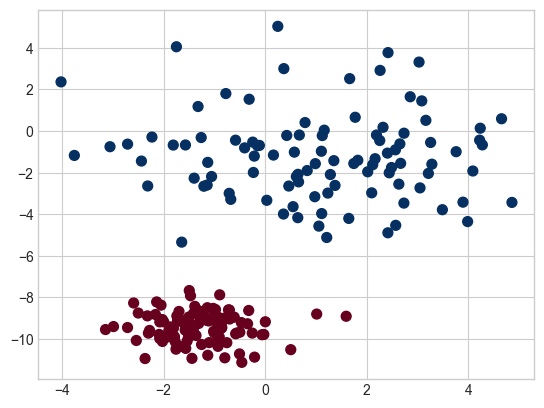

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
 
#X, y = make_moons(n_samples=(500, 100), noise=0.02, random_state=417)
#X, y = make_blobs(300, 2, centers=2, random_state=2, cluster_std=1.5)
X, y = make_blobs([100, 100], 2, random_state=2, cluster_std=[.7, 2])
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

The simplest Gaussian model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions.
This model can be fit by computing the mean and standard deviation of the points within each label, which is all we need to define such a distribution.
The result of this naive Gaussian assumption is shown in the following figure:

[(-6.0265000598619105, 7.289345235408507),
 (-16.68299639571322, 7.542569687185956)]

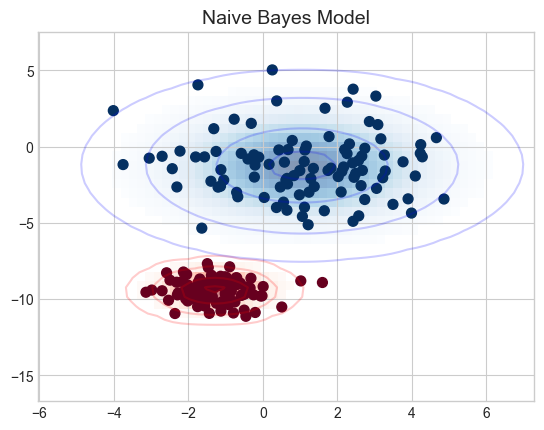

In [ ]:
from sklearn.datasets import make_blobs
#X, y = make_blobs(200, 2, centers=2, random_state=2, cluster_std=1.5)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (X[:,0].min()*1.5, X[:,0].max()*1.5) #(-8, 8)
ylim = (X[:,1].min()*1.5, X[:,1].max()*1.5) #(-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's `sklearn.naive_bayes.GaussianNB` estimator:

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y)

GaussianNB()

Let's generate some new data and predict the label:

In [ ]:
rng = np.random.RandomState(0)
xmin, xmax = X[:,0].min(), X[:,0].max()
ymin, ymax = X[:,1].min(), X[:,1].max()
Xnew = [xmin, ymin] + [xmax - xmin, ymax-ymin] * rng.rand(2000, 2)
#Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is (see the following figure):

(-4.461528216416954, 5.303425000114685, -11.929516466572121, 5.835898660887277)

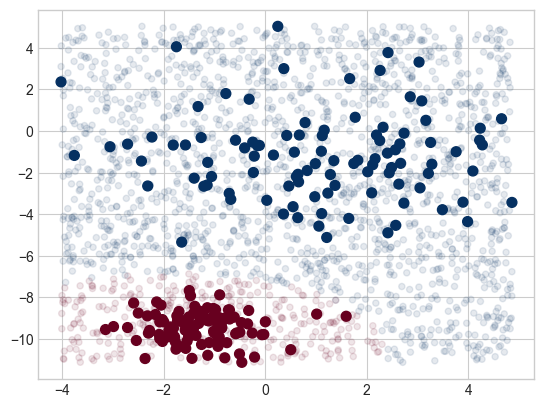

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim)

We see a slightly curved boundary in the classifications—in general, the boundary produced by a Gaussian naive Bayes model will be quadratic.

A nice aspect of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the `predict_proba` method:

In [ ]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.78, 0.22],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ]])

The columns give the posterior probabilities of the first and second labels, respectively.
If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a good place to start.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.
Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a reliable method.

## Linear Discriminant Analysis

Isn't LDA also doing something similar? Let's try fitting the LDA model on the same data and observe what it is upto?

LDA assumes that the data has a **Gaussian distribution** and that the covariance matrices of the different classes are **equal**. It also assumes that the data is linearly separable, meaning that a linear decision boundary can accurately classify the different classes.  QDA allows the covariances to be different.

A nice comparison between GNB and LDA is available at: https://towardsdatascience.com/differences-of-lda-qda-and-gaussian-naive-bayes-classifiers-eaa4d1e999f6

In [ ]:
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
lda = LDA(store_covariance=True)
lda.fit(X, y)

LinearDiscriminantAnalysis(store_covariance=True)

Having fit the model, we can extract the means in the two classes with the `means_` attribute. These are the average of each predictor within each class, and
are used by LDA as estimates of $\mu_k$.  

In [ ]:
print("Mean:", lda.means_, "\nCovariance:", lda.covariance_)
# note, the covariance matrix is the same for all the classes here.

Mean: [[-1.29626246 -9.44295185]
 [ 1.05118969 -1.23753877]] 
Covariance: [[ 2.21364775 -0.15503535]
 [-0.15503535  2.38686128]]


The estimated prior probabilities are stored in the `priors_` attribute.
The package `sklearn` typically uses this trailing `_` to denote
a quantity estimated when using the `fit()` method. We can be sure of which
entry corresponds to which label by looking at the `classes_` attribute.

In [ ]:
lda.classes_

array([0, 1])

The LDA output indicates that $\hat\pi_{0}$ and
$\hat\pi_{1}$.


In [ ]:
lda.priors_


array([0.5, 0.5])

Let's make our model to predict the labels for the synthetic sample data points.

In [ ]:
lda_pred = lda.predict(X)

Let's estimate the confusion matrix for the synthetic sample points.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(lda_pred, y)


array([[100,   1],
       [  0,  99]], dtype=int64)

It is interesting that the TP and TN are pretty high.  And number of misclassified data points is `ZERO`.  But, that's no surprise as the dataset is very much linearly separable.

We can also estimate the
probability of each class for
each point in a training set. Applying a 50% threshold to the posterior probabilities of
being in class one allows us to
recreate the predictions contained in `lda_pred`.

In [ ]:
lda_prob = lda.predict_proba(X)
print(lda_prob[:5])
# threshold Pr(ynew = 1) at 0.5 to cross check the predict() output.
np.all(np.where(lda_prob[:,1] >= 0.5, 1, 0) == lda_pred)


[[9.90722792e-06 9.99990093e-01]
 [9.99998768e-01 1.23182559e-06]
 [5.02692247e-08 9.99999950e-01]
 [1.71431644e-06 9.99998286e-01]
 [9.99999929e-01 7.08783828e-08]]


True

Above, we used the `np.where()`  function that
creates an array with value `'1'` for indices where
the second column of `lda_prob` (the estimated
posterior probability of `'1'`) is greater than 0.5.
For problems with more than two classes the labels are chosen as the class whose posterior probability is highest:

In [ ]:
# multiclass scenarios
np.all([lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred)

True

If we wanted to use a posterior probability threshold other than
50% in order to make predictions, then we could easily do so. If the posterior probability is at least 90%.
We know that the first column of `lda_prob` corresponds to the
label `0` after having checked the `classes_` attribute, hence we use
the column index 0 rather than 1 as we did above.

In [ ]:
# when threshold is not 0.5
np.sum(lda_prob[:,0] > 0.9)

100

__Let's visualize the decision boundary fitted by LDA__

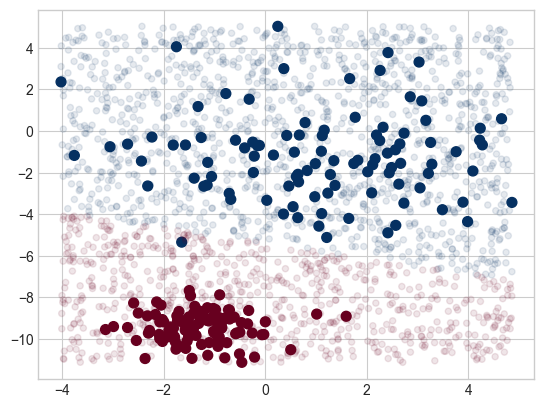

Accuracy: 99 %


In [ ]:
ynew = lda.predict(Xnew)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim)
plt.show()
print("Accuracy:", int(100*np.sum(lda_pred==y)/len(y)), "%")


### Quadratic Discriminant Analysis
Let's fit a QDA model to our data. QDA is
implemented via
`QuadraticDiscriminantAnalysis()`
in the `sklearn` package, which we abbreviate to `QDA()`.
The syntax is very similar to `LDA()`.

In [ ]:
qda = QDA(store_covariance=True, reg_param=.99)
qda.fit(X, y)
print("Mean:", qda.means_, "\nCovariance0:", qda.covariance_[0], "\nCovariance1:", qda.covariance_[1])
qda_pred = qda.predict(X)
# note, the covariance matrix is different for different classes here!!

Mean: [[-1.29626246 -9.44295185]
 [ 1.05118969 -1.23753877]] 
Covariance0: [[ 9.96177643e-01 -2.07627872e-04]
 [-2.07627872e-04  9.95172754e-01]] 
Covariance1: [[ 1.02854251 -0.0029244 ]
 [-0.0029244   1.03304667]]


__Let's visualize the decision boundary fitted by QDA__

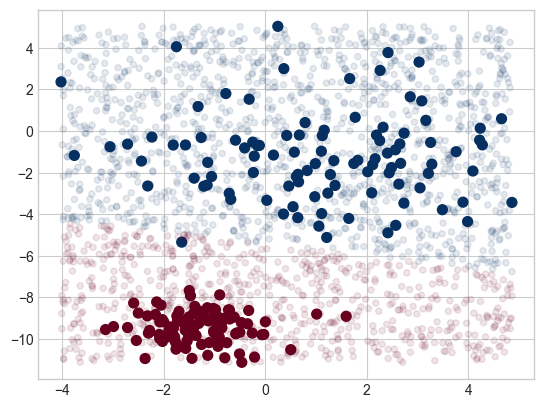

Accuracy:  99 %
[[100   1]
 [  0  99]]


In [ ]:
ynew = qda.predict(Xnew)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim)
plt.show()
print("Accuracy: ", int(100*np.sum(qda_pred==y)/len(y)), "%")
print(confusion_matrix(qda_pred, y))

__the decision bounary is slightly different from the LDA's based on the regularization and the nature of covariance matrices__

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.
The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model it with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
We discussed the extraction of such features from text in Feature Engineering; here we will use the sparse word count features from the 20 Newsgroups corpus made available through Scikit-Learn to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [ ]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories and download the training and testing sets:

In [ ]:
categories = ['talk.politics.guns', 'rec.sport.hockey',
              'sci.space', 'comp.graphics', 'rec.motorcycles']
train = fetch_20newsgroups(subset='train') #, categories=categories)
test = fetch_20newsgroups(subset='test') #, categories=categories)

Here is a representative entry from the data:

In [ ]:
print(train.data[50], train.target[50], train.target_names[train.target[50]])

From: johnc@crsa.bu.edu (John Collins)
Subject: Problem with MIT-SHM
Organization: Boston University
Lines: 27

I am trying to write an image display program that uses
the MIT shared memory extension.  The shared memory segment
gets allocated and attached to the process with no problem.
But the program crashes at the first call to XShmPutImage,
with the following message:

X Error of failed request:  BadShmSeg (invalid shared segment parameter)
  Major opcode of failed request:  133 (MIT-SHM)
  Minor opcode of failed request:  3 (X_ShmPutImage)
  Segment id in failed request 0x0
  Serial number of failed request:  741
  Current serial number in output stream:  742

Like I said, I did error checking on all the calls to shmget
and shmat that are necessary to create the shared memory
segment, as well as checking XShmAttach.  There are no
problems.

If anybody has had the same problem or has used MIT-SHM without
having the same problem, please let me know.

By the way, I am running OpenWin

In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers.
For this we will use the TF-IDF vectorizer, and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data and predict labels for the test data:

In [ ]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, let's take a look at the confusion matrix between the true and predicted labels for the test data (see the following figure):

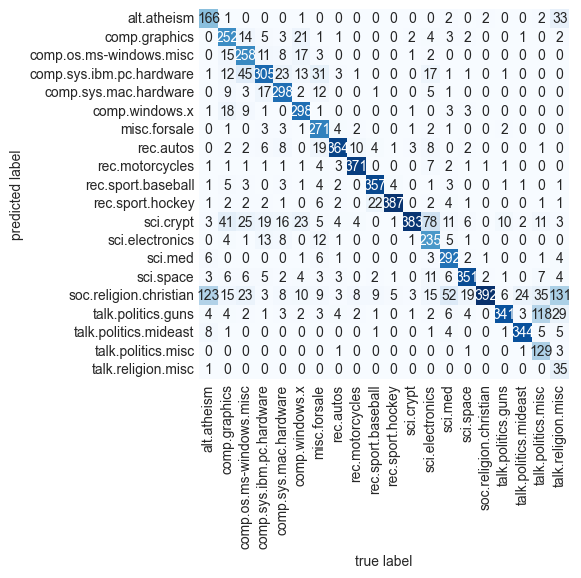

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names,
            cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space discussions from computer discussions, but it gets confused between discussions about religion and discussions about Christianity.
This is perhaps to be expected!

The cool thing here is that we now have the tools to determine the category for *any* string, using the `predict` method of this pipeline.
Here's a utility function that will return the prediction for a single string:

In [ ]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [ ]:
predict_category('MIT shared memory extensions for Python')

'comp.windows.x'

In [ ]:
predict_category('discussing the existence of AK47 AK 47 A.K.47')

'soc.religion.christian'

In [ ]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## When to Use Naive Bayes

Because naive Bayes classifiers make such stringent assumptions about data, they will generally not perform as well as more complicated models.
That said, they have several advantages:

- They are fast for both training and prediction.
- They provide straightforward probabilistic prediction.
- They are often easily interpretable.
- They have few (if any) tunable parameters.

These advantages mean a naive Bayes classifier is often a good choice as an initial baseline classification.
If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem.
If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimensionality of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in *every single dimension* to be close overall).
This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information.
For this reason, simplistic classifiers like the ones discussed here tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.